# Stress Classification from Speech Data with iVectors

In [1]:
import sys
IVECTOR_FRAMEWORK_PATH = '/home/moeflon/Documents/VOP/Models/' # path to iVector framework python files
sys.path.insert(0, IVECTOR_FRAMEWORK_PATH)

In [1]:
from python_speech_features import mfcc
from python_speech_features import nextpow2
import scipy.io.wavfile as wav
import numpy as np
import feature_preprocessing
import gmm_tools
from gmm_tools import GaussianMixtureModel
from sklearn import mixture
from factor_analysis_model import FactorAnalysisModel
from gb_tools import GaussianBackend
from constant_settings import Delta, NormalizationMethod
import glob
import os
import pandas as pd
from factor_analysis_classification_model import FactorAnalysisClassificationModel
from sklearn.model_selection import KFold
from multiprocessing.dummy import Pool as ThreadPool 
from threading import Lock
from joblib import dump, load

In [2]:
DATA_DIR = "/home/moeflon/OneDrive/VOP/Voice and App/" # Directory containing ID subdirectories
LABEL_FILE = "" # CSV file with custom labels for before/after speech per id. columns: [ID, before_MIST, after_MIST]

# Feature Extraction

In [3]:
def extract_data(m_config):
    def extract(file_path):
        (rate, sig) = wav.read(file_path)    
        #extract mfcc features
        mfcc_feat = mfcc(sig, rate, feat_config['winlen'], feat_config['winstep'], feat_config['numcep'], feat_config['nfilt'], nextpow2(rate*feat_config['winlen']), feat_config['lowfreq'], feat_config['highfreq'], feat_config['preemph'], feat_config['ceplifter'], feat_config['winfunc'], feat_config['appendEnergy'], feat_config['winlenEnergy'])
        #construct feature vectors
        mfcc_feat = feature_preprocessing.create_feature_vector(mfcc_feat, m_config['n_static'], m_config['delta'])
        # frame selection - Energy-based Voice Activity Detection
        mfcc_feat = mfcc_feat[mfcc_feat[:, 0] > m_config['log_enrm_threshold'],:]
        # utterance-based feature normalization
        mfcc_feat = feature_preprocessing.feature_normalization(mfcc_feat, m_config['utt_norm'])
        # store features
        return mfcc_feat
    
    datas = []
    for json_file in glob.glob(DATA_DIR + "*/*.json"):
        speaker_dir = "/".join(json_file.split("/")[:-1])
        speaker_id = speaker_dir.split("/")[-1]

        unstressed_file = speaker_dir + "/" + "unstressed.wav"
        stressed_file = speaker_dir + "/" + "stressed.wav"

        unstressed_feat = extract(unstressed_file)
        stressed_feat = extract(stressed_file)

        datas.append(pd.DataFrame({'id': speaker_id, 'stressed': 0, 'file': 'unstressed.wav', 'features': [unstressed_feat]}))
        datas.append(pd.DataFrame({'id': speaker_id, 'stressed': 1, 'file': 'stressed.wav', 'features': [stressed_feat]}))
    data = pd.concat(datas)

    data["id"] = data["id"].astype(int)
    data = data.sort_values(['id', 'stressed'], ascending=[1, 0]).reset_index(drop=True)
    
    
    if LABEL_FILE:
        labels = pd.read_csv(LABEL_FILE)
        for index, row in labels.iterrows():
            if row.after_MIST != -1:
                data.loc[(data['id'] == row.ID) & (data['file'] == 'stressed.wav'), 'stressed'] = row.after_MIST
            if row.before_MIST != -1:
                data.loc[(data['id'] == row.ID) & (data['file'] == 'unstressed.wav'), 'stressed'] = row.before_MIST
        
    return data

In [4]:
def extract_data_freeform(m_config):
    def extract(file_path):
        (rate, sig) = wav.read(file_path)    
        #extract mfcc features
        mfcc_feat = mfcc(sig, rate, feat_config['winlen'], feat_config['winstep'], feat_config['numcep'], feat_config['nfilt'], nextpow2(rate*feat_config['winlen']), feat_config['lowfreq'], feat_config['highfreq'], feat_config['preemph'], feat_config['ceplifter'], feat_config['winfunc'], feat_config['appendEnergy'], feat_config['winlenEnergy'])
        #construct feature vectors
        mfcc_feat = feature_preprocessing.create_feature_vector(mfcc_feat, m_config['n_static'], m_config['delta'])
        # frame selection - Energy-based Voice Activity Detection
        mfcc_feat = mfcc_feat[mfcc_feat[:, 0] > m_config['log_enrm_threshold'],:]
        # utterance-based feature normalization
        mfcc_feat = feature_preprocessing.feature_normalization(mfcc_feat, m_config['utt_norm'])
        # store features
        return mfcc_feat
    
    datas = []
    for json_file in glob.glob(DATA_DIR + "*/*.json"):
        speaker_dir = "/".join(json_file.split("/")[:-1])
        speaker_id = speaker_dir.split("/")[-1]

        freeform_file = speaker_dir + "/" + "stressed_freeform.wav"
        
        freeform_feat = extract(freeform_file)
        
        datas.append(pd.DataFrame({'id': speaker_id, 'stressed': 1, 'file': 'stressed_freeform.wav', 'features': [freeform_feat]}))
    data = pd.concat(datas)

    data["id"] = data["id"].astype(int)
    data = data.sort_values(['id', 'stressed'], ascending=[1, 0]).reset_index(drop=True)
    
    return data

In [5]:
def preprocess_data_spk(input_data, norm):
    res = input_data.copy()
    
    for speaker_idx in input_data['id'].unique():
        df = input_data.loc[input_data['id'] == speaker_idx]
        
        feat_spk = df['features'].values
        utt_idx = df.index
        
        n_frames_spk_utt = [feat.shape[0] for feat in feat_spk]    
        n_frames_spk_utt_cumsum = np.cumsum(n_frames_spk_utt)    
        norm_feat = feature_preprocessing.feature_normalization(np.concatenate(feat_spk, axis=0), norm)
        norm_feat = [norm_feat[n_frames_cumsum-n_frames:n_frames_cumsum, :] for n_frames, n_frames_cumsum in zip(n_frames_spk_utt, n_frames_spk_utt_cumsum)]
       
        for norm_feat_utt, idx in zip(norm_feat, utt_idx):         
            res.loc[idx, 'features'] = [norm_feat_utt]
        
    return res

# Training

In [6]:
def get_ubm(data, m_config, t_config):
    # TRAINING
    ubm_data = preprocess_data_spk(data, m_config['spk_norm'])
    feat_train = ubm_data['features']
    spk_labels_train = ubm_data['id']
    n_components = t_config['n_components']
    
    # train UBM
    print("Started training UBM")
    speech_gmm: mixture = gmm_tools.train_gmm(np.concatenate(feat_train, axis=0), n_components)
    speech_model = GaussianMixtureModel(gmm=speech_gmm, delta=m_config['delta'], n_static=m_config['n_static'], log_enrm_threshold=m_config['log_enrm_threshold'], feat_norm=NormalizationMethod(max(m_config['utt_norm'].value, m_config['spk_norm'].value)))
    print("Done training UBM")
    
    return speech_model, ubm_data

In [7]:
def get_eigenvoice(ubm_data, speech_model, t_config):
    feat_train = ubm_data['features']
    spk_labels_train = ubm_data['id']
    n_components = t_config['n_components']
    
    # train eigenvoice matrix
    print("Started training eigenvoice")
    eigenvoice_model = FactorAnalysisModel(speech_ubm = speech_model)
    eigenvoice_model.fit_total_variability(features=feat_train, rank=t_config['tv_rank'], spk_labels=spk_labels_train)
    print("Done training eigenvoice")
    return eigenvoice_model

In [8]:
def evaluate_kfold(data, speech_model, eigenvoice_model, model_config, training_config, k=4):
    results = []
    train_results = []
    
    print("Starting KFold CV")
    kf = KFold(n_splits=k, random_state=None, shuffle=False)
    for fn, (train_index, test_index) in enumerate(kf.split(data)):
        train = data.iloc[train_index]
        test = data.iloc[test_index]
        
        train = preprocess_data_spk(train, model_config['spk_norm'])
        test = preprocess_data_spk(test, model_config['spk_norm'])
        x = train['features']
        y = train['stressed']
        x_t = test['features']
        y_t = test['stressed']
        
        # train an emotion variability model with a Gaussian Backend as final classifier
        spk_labels_train = train['id']
        emo_classifier = FactorAnalysisClassificationModel(eigenvoice_model)
        emo_classifier.fit(x, spk_labels_train, y, within_class_R=model_config['within_emo_rank'], classes=['unstressed','stressed'], score_norm=model_config['score_norm'], remove_variability_class_idx=0 if model_config['remove_neutral_shift'] else None, adapt_UBM=model_config['adapt_UBM'])

        # EVALUATION
        spk_labels_test = test['id']
        estimated_label, posteriors = emo_classifier.evaluate(x_t, spk_labels = spk_labels_test)
        estimated_label_train, posteriors = emo_classifier.evaluate(x, spk_labels = spk_labels_train)
        
        result = estimated_label[np.where(estimated_label == y_t)].size / y_t.size
        result_train = estimated_label_train[np.where(estimated_label_train == y)].size / y.size
        results.append(result)
        train_results.append(result_train)

    results = np.asarray(results)
    train_results = np.asarray(train_results)
    return np.average(results), np.average(train_results), np.std(results), np.std(train_results)

In [9]:
def ev(data, ubm, eigenvoice, c, r, emo_rank, a, s, sn, un, n_static, delta, enrm_threshold): 
    test, train, test_std, train_std = evaluate_kfold(data, ubm, eigenvoice, 
    {   
        'n_static': n_static,
        'delta': delta, 
        'log_enrm_threshold': enrm_threshold,
        'utt_norm': un,
        'spk_norm': sn,
        'within_emo_rank': emo_rank,
        'remove_neutral_shift': a,
        'adapt_UBM': a,
        'score_norm': s,  
    },
    {   
        'n_components': c,
        'tv_rank': r
    })

    return {'n_components': c, 'tv_rank': r , 'emo_rank': emo_rank, 'adapt_UBM': a, 'score_norm': s, 'spk_norm': sn, 'utt_norm': un, 'n_static': n_static, 'delta': delta, 'enrm_threshold': enrm_threshold, 'train': train, 'test': test, 'train_std': train_std, 'test_std': test_std}

## Cross-Validated GridSearch

In [35]:
res_file = 'results_ivector_gridsearch.csv'
if not os.path.isfile(res_file):
    n_statics = [40]
    deltas = [Delta.sdc]
    enrm_thresholds = [-1000]
    components = [128]
    ranks = [80]
    emo_ranks = [3]
    adapt = [True]
    utt_norms = [NormalizationMethod.cmvn]
    score_norms = [NormalizationMethod.none]
    spk_norms = [NormalizationMethod.none]

    results = pd.DataFrame(columns=['n_components', 'tv_rank', 'emo_rank', 'adapt_UBM', 'score_norm', 'spk_norm', 'utt_norm', 'n_static', 'delta', 'enrm_threshold', 'train', 'test', 'train_std', 'test_std'])

    pool = ThreadPool()
    lock = Lock()

    feat_config = {
        'winlen': 0.025,    
        'winstep': 0.010,
        'numcep': 20,
        'nfilt': 24,
       'lowfreq': 0,    
        'highfreq': 8000,
        'preemph': 0.97,
        'ceplifter': 0,
        'winlenEnergy': 5,
        'appendEnergy': True,
        'winfunc': lambda x:np.hamming(x)
    }

    i = 0
    total = len(n_statics) * len(deltas) * len(enrm_thresholds) * len(components) * len(ranks) * len(emo_ranks) * len(adapt) * len(utt_norms) * len(score_norms) * len(spk_norms)
    
    print("Total: {} fits".format(total))
    def cb(res):
        lock.acquire()
        global results
        global i
        results = results.append(res, ignore_index=True)
        i += 1
        print("Done {}/{}".format(i, total))
        print(res)
        lock.release()

    for n_static in n_statics:
        for delta in deltas:
            for enrm_threshold in enrm_thresholds:
                for un in utt_norms:
                    print("Extracting data")
                    data = extract_data({   
                        'n_static': n_static,
                        'delta': delta, 
                        'log_enrm_threshold': enrm_threshold,
                        'utt_norm': un, 
                    })
                    for c in components:
                        for sn in spk_norms:
                            ubm, ubm_data = get_ubm(data, {   
                                'n_static': n_static,
                                'delta': delta, 
                                'log_enrm_threshold': enrm_threshold,
                                'utt_norm': un,
                                'spk_norm': sn,
                            },
                            {   
                                'n_components': c,
                            })
                            for r in ranks:
                                eigenvoice = get_eigenvoice(ubm_data, ubm, {   
                                    'n_components': c,
                                    'tv_rank': r
                                })
                                for emo_rank in emo_ranks:
                                    for a in adapt:
                                        for s in score_norms:
                                            pool.apply_async(ev, [data, ubm, eigenvoice, c, r, emo_rank, a, s, sn, un, n_static, delta, enrm_threshold], callback=cb)


    pool.close()
    pool.join()
    results.to_csv(res_file, index=False)
else:
    results = pd.read_csv(res_file)

In [36]:
r = results.sort_values('test', ascending=0).reset_index()
opt_params = r.loc[0]
feat_config = {
    'winlen': 0.025,    
    'winstep': 0.010,
    'numcep': 20,
    'nfilt': 24,
    'lowfreq': 0,    
    'highfreq': 8000,
    'preemph': 0.97,
    'ceplifter': 0,
    'winlenEnergy': 5,
    'appendEnergy': True,
    'winfunc': lambda x:np.hamming(x)
}

model_config = {
    'n_static': opt_params.n_static,
    'delta': eval(opt_params.delta),
    'log_enrm_threshold': opt_params.enrm_threshold,
    'utt_norm': eval(opt_params.utt_norm),
    'spk_norm': eval(opt_params.spk_norm),
    'within_emo_rank': opt_params.emo_rank,
    'remove_neutral_shift': opt_params.adapt_UBM,
    'adapt_UBM': opt_params.adapt_UBM,
    'score_norm': eval(opt_params.score_norm),
}

training_config = {
    'n_components': opt_params.n_components, 
    'tv_rank': opt_params.tv_rank
}

opt_configs = (model_config, training_config)

In [37]:
opt_configs

({'n_static': 40,
  'delta': <Delta.sdc: 3>,
  'log_enrm_threshold': -1000,
  'utt_norm': <NormalizationMethod.cmvn: 2>,
  'spk_norm': <NormalizationMethod.none: 0>,
  'within_emo_rank': 3,
  'remove_neutral_shift': True,
  'adapt_UBM': True,
  'score_norm': <NormalizationMethod.none: 0>},
 {'n_components': 128, 'tv_rank': 80})

## Retrain with all data

In [13]:
data = extract_data(model_config)
ubm, ubm_data = get_ubm(data, model_config, training_config)
eigenvoice = get_eigenvoice(ubm_data, ubm, training_config)
train = preprocess_data_spk(data, model_config['spk_norm'])
x = train['features']
y = train['stressed']
spk_labels_train = data['id']
emo_classifier = FactorAnalysisClassificationModel(eigenvoice)
emo_classifier.fit(x, spk_labels_train, y, within_class_R=model_config['within_emo_rank'], classes=['unstressed','stressed'], score_norm=model_config['score_norm'], remove_variability_class_idx=0 if model_config['remove_neutral_shift'] else None, adapt_UBM=model_config['adapt_UBM'])
dump(emo_classifier, 'ivector.joblib')

Started training UBM
Done training UBM
Started training eigenvoice
Done training eigenvoice


['ivector.joblib']

# Results

In [14]:
# Freeform stress probabilities
ff = extract_data_freeform(model_config)
ff = preprocess_data_spk(ff, model_config['spk_norm'])
spk_labels = ff['id']

predicted_labels = pd.DataFrame(columns=['id', 'freeform'])
predicted_labels['id'] = ff['id'].unique()

pred, posteriors = emo_classifier.evaluate(ff['features'], spk_labels = spk_labels)
predicted_labels['freeform'] = posteriors[1, :]
predicted_labels.to_csv("ivector_predicted_probabilities_freeform.csv", index=False)

In [15]:
# Stress probabilities
predicted_labels = pd.DataFrame(columns=['id', 'before', 'after'])
predicted_labels['id'] = data['id'].unique()
data = extract_data(model_config)
ubm, ubm_data = get_ubm(data, model_config, training_config)
eigenvoice = get_eigenvoice(ubm_data, ubm, training_config)

kf = KFold(n_splits=4, shuffle=False)
for fn, (train_index, test_index) in enumerate(kf.split(data)):
    train = data.iloc[train_index]
    test = data.iloc[test_index]

    train = preprocess_data_spk(train, model_config['spk_norm'])
    test = preprocess_data_spk(test, model_config['spk_norm'])
    x = train['features']
    y = train['stressed']
    x_t = test['features']
    y_t = test['stressed']
    
    spk_labels_train = train['id']
    emo_classifier = FactorAnalysisClassificationModel(eigenvoice)
    emo_classifier.fit(x, spk_labels_train, y, within_class_R=model_config['within_emo_rank'], classes=['unstressed','stressed'], score_norm=model_config['score_norm'], remove_variability_class_idx=0 if model_config['remove_neutral_shift'] else None, adapt_UBM=model_config['adapt_UBM'])

    for idx, row in test.iterrows():
        label, posteriors = emo_classifier.evaluate([row['features']])
        posterior_stressed = posteriors[1][0]
            
        if 'unstressed' in row.file:
            predicted_labels.loc[predicted_labels.id == row.id, 'before'] = posterior_stressed
        else:
            predicted_labels.loc[predicted_labels.id == row.id, 'after'] = posterior_stressed

predicted_labels.to_csv("ivector_predicted_probabilities.csv", index=False)

Started training UBM
Done training UBM
Started training eigenvoice
Done training eigenvoice


In [20]:
# Precision, recall, accuracy
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

res_recall = []
res_precision = []
res_accuracy = []


kf = KFold(n_splits=4, random_state=None, shuffle=False)
for fn, (train_index, test_index) in enumerate(kf.split(data)):
    train = data.iloc[train_index]
    test = data.iloc[test_index]

    train = preprocess_data_spk(train, model_config['spk_norm'])
    test = preprocess_data_spk(test, model_config['spk_norm'])
    x = train['features']
    y = train['stressed']
    x_t = test['features']
    y_t = test['stressed']

    # train an emotion variability model with a Gaussian Backend as final classifier
    spk_labels_train = train['id']
    emo_classifier = FactorAnalysisClassificationModel(eigenvoice)
    emo_classifier.fit(x, spk_labels_train, y, within_class_R=model_config['within_emo_rank'], classes=['unstressed','stressed'], score_norm=model_config['score_norm'], remove_variability_class_idx=0 if model_config['remove_neutral_shift'] else None, adapt_UBM=model_config['adapt_UBM'])

    # EVALUATION
    spk_labels_test = test['id']
    pred, posteriors = emo_classifier.evaluate(x_t, spk_labels = spk_labels_test)

    res_recall.append(recall_score(y_t, pred))
    res_precision.append(precision_score(y_t, pred))
    res_accuracy.append(accuracy_score(y_t, pred))

recall = np.average(res_recall)
precision = np.average(res_precision)
accuracy = np.average(res_accuracy)

print("recall: {}, precision: {}, accuracy: {}".format(recall, precision, accuracy))

recall: 0.8581081081081081, precision: 0.8949734398263811, accuracy: 0.8783783783783783


# Visualizations

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.model_selection import LearningCurve
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import DiscriminationThreshold
from yellowbrick.style import resolve_colors

In [57]:
# Function to plot learning curves from gridsearch results
# adapted from https://matthewbilyeu.com/blog/2019-02-05/validation-curve-plot-from-gridsearchcv-results
def plot_grid_search_validation_curve(grid, param_to_vary,
                                      title='Validation Curve', ylim=None,
                                      xlim=None, log=None, best_params_=None, xlabel=None, ylabel=None, file=None):
    """Plots train and cross-validation scores from a GridSearchCV instance's
    best params while varying one of those params."""
    grid = grid.copy()
    df_cv_results = grid
    param_cols = [c for c in df_cv_results.columns if c not in ['train', 'test', 'train_std', 'test_std']]
    param_ranges = [df_cv_results[p].unique() for p in param_cols]
    param_ranges_lengths = [len(pr) for pr in param_ranges]

    param_to_vary_idx = param_cols.index(param_to_vary)    

    slices = []
    
    r = grid.sort_values(['test', 'train'], ascending=[0, 1]).reset_index(drop=True)
    if best_params_ == None:
        best_params_ = r.loc[0].to_dict()
    best_params_.pop('train')
    best_params_.pop('test')
    best_params_.pop('train_std')
    best_params_.pop('test_std')
    best_params_.pop(param_to_vary)
    qry = ' and '.join(['{} == "{}"'.format(k,v) if isinstance(v, str) else '{} == {}'.format(k,v) for k,v in best_params_.items()])

    varied = grid.query(qry)    
    train_scores_mean = varied['train']
    valid_scores_mean = varied['test']
    train_scores_std = varied['train_std']
    valid_scores_std = varied['test_std']

    plt.clf()
    fig, ax = plt.subplots()
    fig.set_size_inches(6,4)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    if (ylim is None):
        plt.ylim(0.0, 1.1)
    else:
        plt.ylim(*ylim)

    if (not (xlim is None)):
        plt.xlim(*xlim)

    lw = 2

    plot_fn = plt.plot
    colors = resolve_colors(n_colors=2)
    
    param_range = param_ranges[param_to_vary_idx]
    sort = pd.DataFrame(zip(param_range, train_scores_mean, valid_scores_mean, train_scores_std, valid_scores_std), columns=['range', 'train', 'test', 'trainstd', 'teststd'])
    sort = sort.sort_values('range').reset_index()
    
    param_range = sort['range']
    train_scores_mean = sort['train']
    valid_scores_mean = sort['test']
    train_scores_std = sort['trainstd']
    valid_scores_std = sort['teststd']
    plot_fn(param_range, train_scores_mean, 'd-', label='Training Score', color=colors[0],
            lw=lw)
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color=colors[0], lw=lw)
    plot_fn(param_range, valid_scores_mean, 'd-', label='Cross Validation Score', lw=lw, color=colors[1])
    plt.fill_between(param_range, valid_scores_mean - valid_scores_std,
                     valid_scores_mean + valid_scores_std, alpha=0.1,
                     color=colors[1], lw=lw)

    plt.legend(loc='lower right')

    plt.show()
    fig.savefig(file, dpi=800)

In [51]:
# Wrapper around this iVector method, for use in sklearn visualization methods
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
from factor_analysis_classification_model import FactorAnalysisClassificationModel

class iVectorWrapper(BaseEstimator, ClassifierMixin):  
    def __init__(self, eigenvoice, model_config):
        """
        Called when initializing the classifier
        """
        self.model_config = model_config
        self.training_config = training_config
        self.eigenvoice = eigenvoice
        
    def fit(self, X, y=None): 
        y_t = y
        y_spk = X['id']
        X = X['features']
        
        self.emo_classifier = FactorAnalysisClassificationModel(self.eigenvoice)
        self.emo_classifier.fit(X, y_spk, y_t, within_class_R=self.model_config['within_emo_rank'], classes=['unstressed','stressed'], score_norm=self.model_config['score_norm'], remove_variability_class_idx=0 if self.model_config['remove_neutral_shift'] else None, adapt_UBM=self.model_config['adapt_UBM'])

    def _meaning(self, x):
        # returns True/False according to fitted classifier
        # notice underscore on the beginning
        return(True if self.emo_classifier else False)

    def predict(self, X, y=None):
        y_spk = X['id']
        X = X['features']
        try:
            getattr(self, "emo_classifier")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        
        label, _ = self.emo_classifier.evaluate(X, spk_labels = y_spk)
        return(label.transpose())
    
    def predict_proba(self, X, y=None):
        y_spk = X['id']
        X = X['features']
        label, posteriors = self.emo_classifier.evaluate(X, spk_labels = y_spk)
        return posteriors.transpose()
    
    def score(self, X, y=None):
        X = X['features']
        y_t = y
        estimated_labels = self.predict(X)
        result = estimated_label[np.where(estimated_labels == y_t)].size / y_t.size

        return result 

In [45]:
data = extract_data(model_config)
ubm, ubm_data = get_ubm(data, model_config, training_config)
eigenvoice = FactorAnalysisModel(speech_ubm = ubm)
eigenvoice.fit_total_variability(features=ubm_data['features'], rank=training_config['tv_rank'], spk_labels=ubm_data['id'])

Started training UBM
Done training UBM


In [52]:
ivector = iVectorWrapper(eigenvoice, model_config)

## Learning curve

<IPython.core.display.Javascript object>


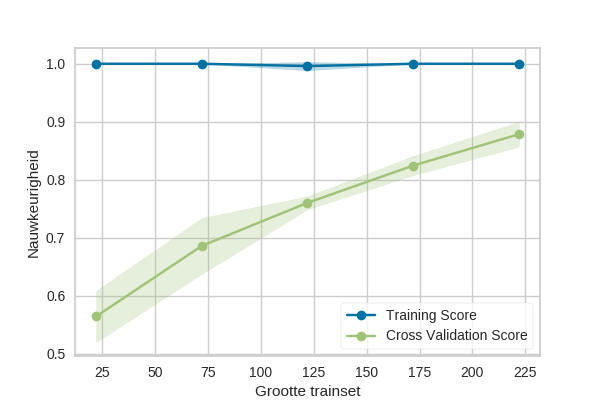

In [53]:
fig, ax = plt.subplots()
fig.set_size_inches(6,4)

kf = KFold(n_splits=4, shuffle=False)
visualizer = LearningCurve(ivector, scoring='accuracy', cv=kf, groups=data['id'], ax=ax, shuffle=True)
visualizer.fit(data, data['stressed'])
visualizer.finalize()
visualizer.set_title('')
visualizer.set_title('')
visualizer.ax.set_xlabel('Grootte trainset')
visualizer.ax.set_ylabel('Nauwkeurigheid');
plt.show()
fig.savefig('ivector_leercurve.png', dpi=800)

## Discrimination threshold

<IPython.core.display.Javascript object>


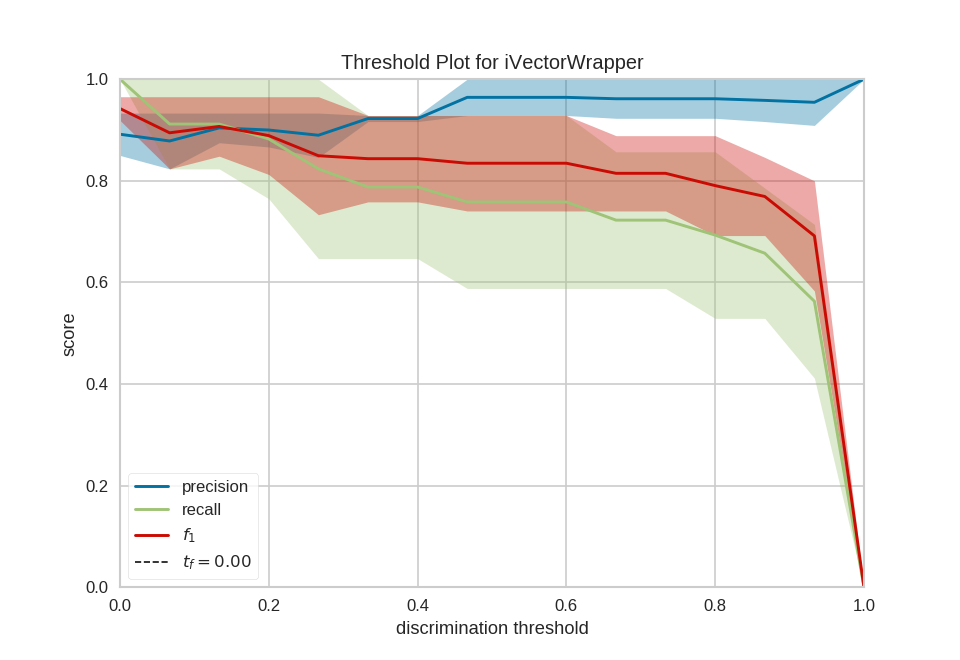

In [61]:
fig, ax = plt.subplots()

visualizer = DiscriminationThreshold(ivector, exclude="queue_rate", n_trials=2)
visualizer.fit(data, data['stressed'])
visualizer.poof()

## Cross-validation curves

<Figure size 432x288 with 0 Axes>

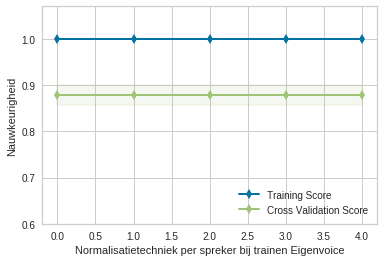

In [67]:
r = results.copy()
r['spk_norm'] = r['spk_norm'].apply(lambda x: eval(x).value)
plot_grid_search_validation_curve(r, 'spk_norm', title='', xlabel='Normalisatietechniek per spreker bij trainen Eigenvoice', ylabel='Nauwkeurigheid', file='ivector_spk_norm.png', ylim=(0.6,1.07))

<Figure size 432x288 with 0 Axes>

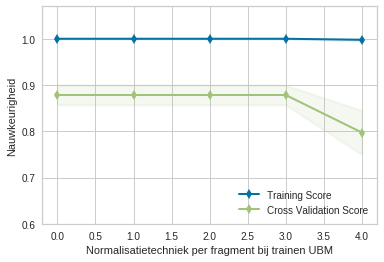

In [68]:
r = results.copy()
r['utt_norm'] = r['utt_norm'].apply(lambda x: eval(x).value)
plot_grid_search_validation_curve(r, 'utt_norm', title='', xlabel='Normalisatietechniek per fragment bij trainen UBM', ylabel='Nauwkeurigheid', file='ivector_utt_norm.png', ylim=(0.6,1.07))

<Figure size 432x288 with 0 Axes>

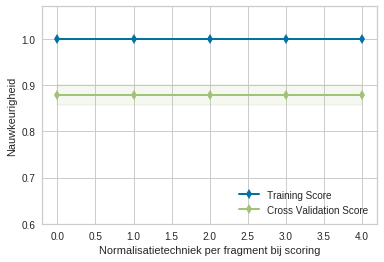

In [71]:
r = results.copy()
r['score_norm'] = r['score_norm'].apply(lambda x: eval(x).value)
plot_grid_search_validation_curve(r, 'score_norm', title='', xlabel='Normalisatietechniek per fragment bij scoring', ylabel='Nauwkeurigheid', file='ivector_score_norm.png', ylim=(0.6,1.07))

<Figure size 432x288 with 0 Axes>

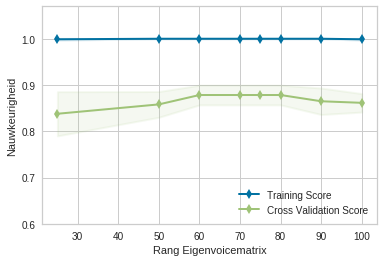

In [70]:
plot_grid_search_validation_curve(results, 'tv_rank', title='', xlabel='Rang Eigenvoicematrix', ylabel='Nauwkeurigheid', file='ivector_tv_rank.png', ylim=(0.6,1.07))

<Figure size 432x288 with 0 Axes>

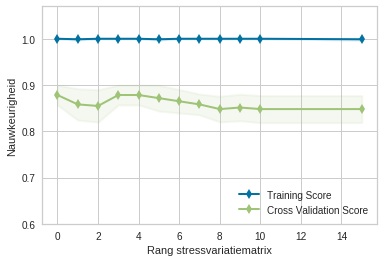

In [43]:
plot_grid_search_validation_curve(results, 'emo_rank', title='', xlabel='Rang stressvariatiematrix', ylabel='Nauwkeurigheid', file='ivector_emo_rank.png', ylim=(0.6,1.07))

<Figure size 432x288 with 0 Axes>

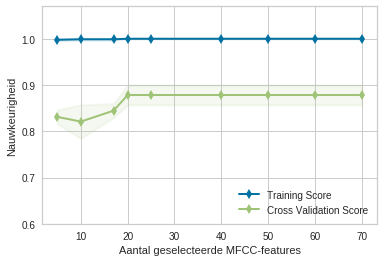

In [58]:
plot_grid_search_validation_curve(results, 'n_static', title='', xlabel='Aantal geselecteerde MFCC-features', ylabel='Nauwkeurigheid', file='ivector_n_static.png', ylim=(0.6,1.07))

<Figure size 432x288 with 0 Axes>

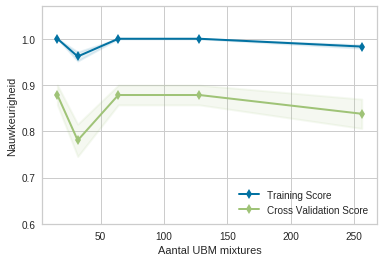

In [41]:
plot_grid_search_validation_curve(results, 'n_components', title='', xlabel='Aantal UBM mixtures', ylabel='Nauwkeurigheid', file='ivector_n_components.png', ylim=(0.6,1.07))